# Práctica 10: Estimación del rendimiento.

## Realizado por:
- Susana Suárez Mendoza
- Mara Pareja del Pino

In [29]:
import pandas as pd
import numpy as np
from sklearn import svm, model_selection, metrics, naive_bayes, linear_model, neighbors, preprocessing
import matplotlib.pyplot as plt

### Ejercicio 1: Cálculo de medidas rendimiento.

In [30]:
datos_train = pd.read_csv("./datos/CelebA-10K-train.csv")
datos_test = pd.read_csv("./datos/CelebA-10K-test.csv")

X_train, y_train, X_test, y_test = datos_train.iloc[:,2:], datos_train.iloc[:,1], datos_test.iloc[:,2:], datos_test.iloc[:,1]

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

1. Entrenar cinco clasificadores diferentes de los vistos hasta ahora en las clases prácticas de la asignatura a partir del conjunto de datos descritos en el apartado 10.2.

In [31]:
clasificadores = [linear_model.LogisticRegression(), naive_bayes.GaussianNB(), neighbors.KNeighborsClassifier(), svm.SVC(), linear_model.Perceptron()]
modelos = []

for clasificador in clasificadores:
    clasificador.fit(X_train, y_train)
    modelos.append(clasificador)

2. Obtener y mostrar gráficamente las matrices de confusión para cada uno de ellos.

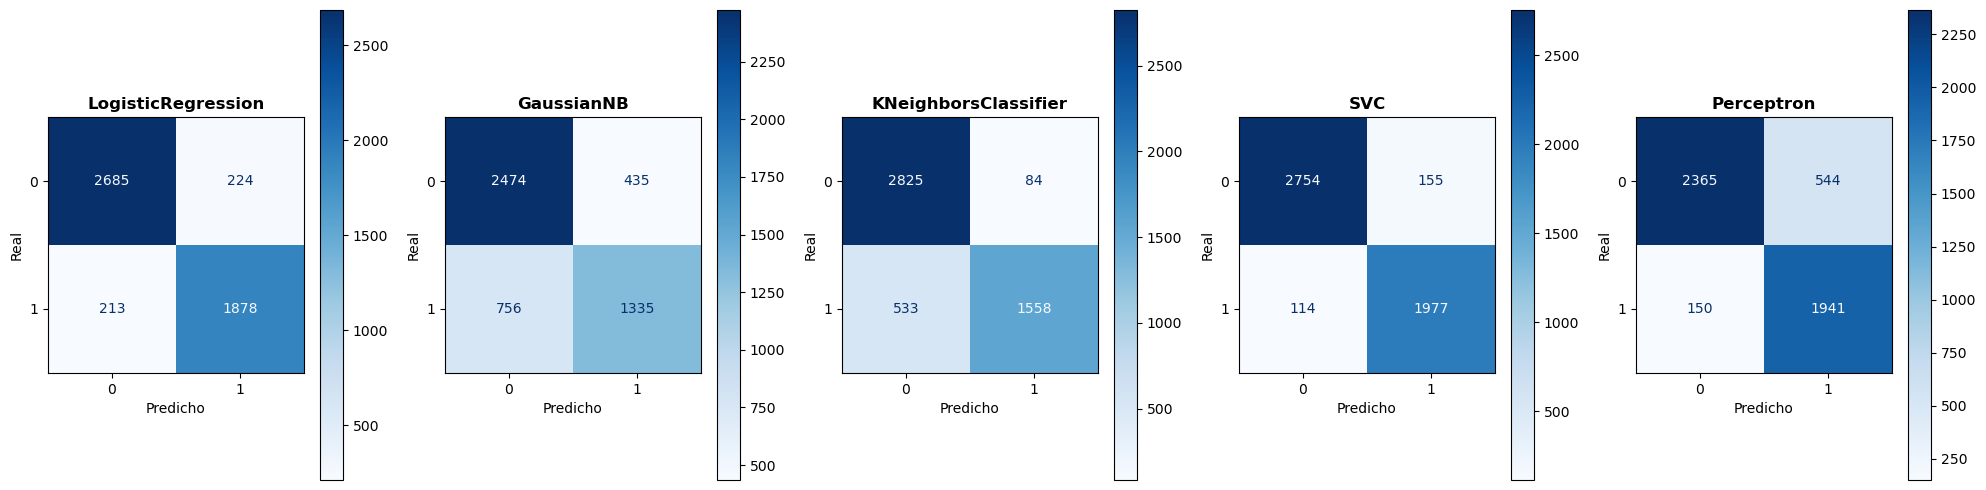

In [32]:
matrices = []

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, modelo in enumerate(modelos):
    y_pred = modelo.predict(X_test)
    matriz_confusion = metrics.confusion_matrix(y_test, y_pred)
    matrices.append(matriz_confusion)
    metrics.ConfusionMatrixDisplay(confusion_matrix=matriz_confusion).plot(ax=axs[i], cmap=plt.cm.Blues)

    axs[i].set_title(clasificadores[i].__class__.__name__, fontweight="bold")
    axs[i].set_xlabel("Predicho")
    axs[i].set_ylabel("Real")

plt.tight_layout()
plt.show()

3. A partir de los valores de la matriz de confusión calcular: tasa de acierto (accuracy), sensibilidad (recall), precisión (precision), especifidad y medida F1, para cada uno de los
clasificadores y mostrarlos en forma de tabla.

In [33]:
accuracies = []

sensibilidades = []
especificidades = []
precisiones = []
f1_scores = []

for matriz in matrices:
    accuracies.append((matriz[0][0] + matriz[1][1]) / (matriz[0][0] + matriz[1][1] + matriz[0][1] + matriz[1][0]))
    sensibilidades.append(matriz[0][0] / (matriz[0][0] + matriz[1][0]))
    especificidades.append(matriz[1][1] / (matriz[1][1] + matriz[0][1]))
    precisiones.append(matriz[0][0] / (matriz[0][0] + matriz[0][1]))
    f1_scores.append(2 / ((1 / sensibilidades[-1]) + (1 / precisiones[-1])))

nombres = [clasificador.__class__.__name__ for clasificador in clasificadores]
resultados = pd.DataFrame({"Accuracy": accuracies, "Sensibilidad": sensibilidades, "Especificidad": especificidades, "Precision": precisiones, "F1-score": f1_scores}, index=nombres)
display(resultados)

,Accuracy,Sensibilidad,Especificidad,Precision,F1-score
LogisticRegression,0.9126,0.926501,0.893435,0.922998,0.924746
GaussianNB,0.7618,0.765944,0.754237,0.850464,0.805994
KNeighborsClassifier,0.8766,0.841275,0.948843,0.971124,0.901548
SVC,0.9462,0.960251,0.927298,0.946717,0.953436
Perceptron,0.8612,0.940358,0.781087,0.812994,0.872050


Por un lado, el modelo que mejor clasifica las muestras positivas, además de tener una mayor exactitud y cuyo F-Score es mayor es la Máquina de Vectores de Soporte (SVC). Sin embargo, aquel que clasifica mejor las muestras negativas y tiene una mayor precisión es el KNeighborsClassifier.

En líneas generales el clasificador que obtiene myores valores de las medidas formales de eficacia de la clasificación es el SVC ya que en ninguna de las medidas baja del 0.9.

### Ejercicio 2: Espacio ROC.

Anteriormente ya hemos guardado los clasificadores entrenados y sus matrices en listas por lo que no es necesario volver a calcularlos.

3. A partir de los valores de la matriz de confusión, calcular el TPR y FPR de cada clasificador y mostrarlo en el espacio ROC.

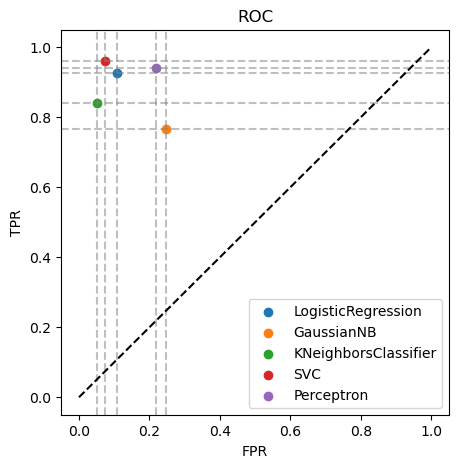

In [34]:
TPRs = []
FPRs = []

for matriz in matrices:
    TPRs.append(matriz[0][0] / (matriz[0][0] + matriz[1][0]))
    FPRs.append(matriz[0][1] / (matriz[0][1] + matriz[1][1]))

plt.figure(figsize=(5, 5))
for i in range(len(TPRs)):
    plt.scatter(FPRs[i], TPRs[i], label=nombres[i])
    plt.axvline(x=FPRs[i], color="gray", alpha=0.5, linestyle="--")
    plt.axhline(y=TPRs[i], color="gray", alpha=0.5, linestyle="--")

plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

4. Analizar el resultado obtenido.

Observando la gráfica podemos decir que el clasificador más cecano a la clasificación perfecta (todos verdaderos positivos y ningún falso positivo) es la Máquina de Vector de Soporte.
Y el peor de ellos es el clasificador GaussianNB encontrandose entre ellos el resto de clasificadores con valores similares.

### Ejercicio 3: Curva ROC.

1. Entrenar un clasificador bayesiano, un clasificador por regresión logística y una máquina de vectores soporte con los datos descritos en la sección 10.2.

In [106]:
clasificadores = [naive_bayes.GaussianNB(), linear_model.LogisticRegression(), svm.SVC(probability=True)]
modelos = []

for clasificador in clasificadores:
    clasificador.fit(X_train, y_train)
    modelos.append(clasificador)

2. Dibujar en un único gráfico las curvas ROC de los tres clasificadores anteriores.

In [107]:
probabilidades = []

for modelo in modelos:
    probabilidades.append(modelo.predict_proba(X_test))

In [108]:
umbrales = [i / 1000 for i in range(1001)]

TPRs = []
FPRs = []

for i, modelo in enumerate(modelos):
    tpr = []
    fpr = []

    for umbral in umbrales:
        y_pred = [1 if prob[1] >= umbral else 0 for prob in probabilidades[i]]
        matriz_confusion = metrics.confusion_matrix(y_test, y_pred)
        tpr.append(matriz_confusion[0][0] / (matriz_confusion[0][0] + matriz_confusion[0][1]))
        fpr.append(matriz_confusion[1][0] / (matriz_confusion[1][0] + matriz_confusion[1][1]))
        
    TPRs.append(tpr)
    FPRs.append(fpr)

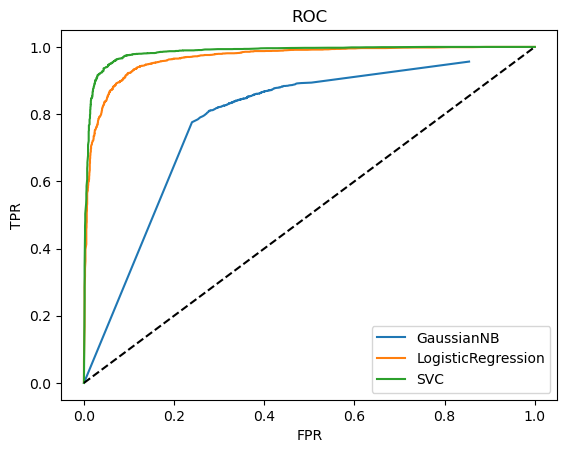

In [109]:
nombres = [clasificador.__class__.__name__ for clasificador in clasificadores]

for i in range(len(TPRs)):
    plt.plot(FPRs[i], TPRs[i], label=nombres[i])

plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

3. Analizar el resultado obtenido.

El mejor clasificador cuya curva ROC es la mejor es La Máquina de Vectores de soporte siendo la curva más próxima a la posición del punto 0, 1.